In [77]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Ride Hailing Apps: A demographic investigation

## Introduction

Since the wide spread adoption of smart phones around 5 years ago, multiple industries have been disrupted. 
None more so than the taxi industry, which has seen traditional taxi cab monopolies come under attack by newcomers such as uber and lyft. 
Our goal was to evaluate the future growth of ride sharing apps companies such as uber.
Specifically, we identified one key area of analysis - the demograhics.
We hypothesise that uber adoption has been largely driven by younger demographics, as they tend to be the early adapters of a lot of technology.
Hence, a key indicator of future growth will be the uptake by other age demographics, and we will show that there is growth in these areas.

## Long Term Demographics Analysis

We combine the demographic data of the different areas of New York to estimate the age profiles of people who ordered rides. 
One way to think about this analysis is that is a comparison of pickups in "young areas" (Williamsburg, Boroug Park, Belmont - 20) with "older areas" (West Brighton, Terrace-Clearview, Hyde Park - 56).
We're interested in the fractional growth of each demographic: even though the number of older people using Uber remains relatively small by comparison with younger people, there may be a dramatic increase in uptake, relatively speaking.

In [11]:
# Import modules

from __future__ import division, print_function
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import polygons as p
import os 
import seaborn; seaborn.set()  # plot styling
%matplotlib inline

In [75]:
# Let's define some useful functions

def get_nta_codes(lons_lats,geo):

    nta_codes = np.empty(lons_lats.shape[0],dtype='object')
    nta_codes[:] = ''

    for nta_code in geo:

        pts = geo[nta_code].dropna().values
        pts = pts.reshape((int(pts.shape[0]/2),2))
        nta_Path = mplPath.Path(pts)
        is_in_nta = nta_Path.contains_points(lons_lats)
        nta_codes[is_in_nta] = nta_code

    return nta_codes

def add_pickup_nta_codes(taxi_data,geo):

    lons_lats = taxi_data.loc[:,['pickup_longitude','pickup_latitude']].as_matrix()
    nta_codes = get_nta_codes(lons_lats,geo)
    taxi_data.loc[:,'pickup_NTA_code'] = pd.Series(nta_codes,index=taxi_data.index)

    return None

def add_dropoff_nta_codes(taxi_data,geo):

    lons_lats = taxi_data.loc[:,['dropoff_longitude','dropoff_latitude']].as_matrix()
    nta_codes = get_nta_codes(lons_lats,geo)
    taxi_data.loc[:,'dropoff_NTA_code'] = pd.Series(nta_codes,index=taxi_data.index)

    return None

Here we plot boundaries of the NYC areas codes

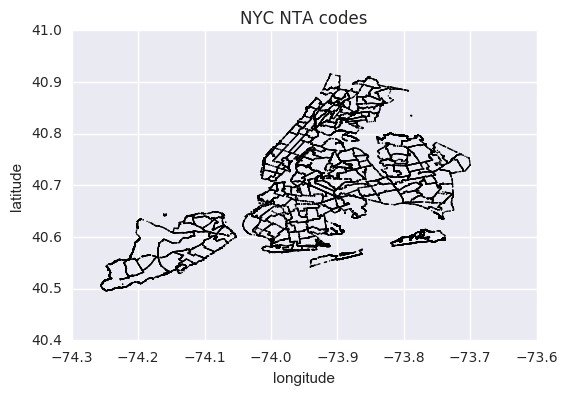

In [84]:
for nta_code in geo:

        pts = geo[nta_code].dropna().values
        pts = pts.reshape((int(pts.shape[0]/2),2))
        plt.scatter(pts[:,0],pts[:,1],s=1,c='k',edgecolors='none')

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("NYC NTA codes");

How does uber usage change over time?
Here plot both the Uber data, summed daily, with a 5 day rolling average for clarity.

From this plot we can see that while uber cabs are not as common, they are growing steadily whike yellow cabs are staying stagnent

The gap in the middle is explained by a period of missing data

/Users/liam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False).mean()
/Users/liam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False).mean()


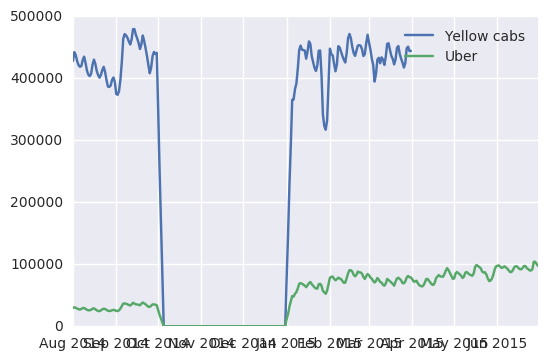

In [87]:
daily_y = pd.read_pickle('../Data/daily_y.pickle')
daily_uber = pd.read_pickle('../Data/daily_uber.pickle')

plt.plot(pd.stats.moments.rolling_mean(daily_y, 5).truncate(before=np.datetime64('2014-08-01')), label='Yellow cabs')
plt.plot(pd.stats.moments.rolling_mean(daily_uber, 5).truncate(before=np.datetime64('2014-08-01')), label='Uber')
plt.legend();

In [74]:
# Load data 
# Date-times have been parsed. This takes a while, so we load pickled versions

# zones = pd.read_csv('../Data/zones.csv')
# zones = zones[['location_id', 'nta_code']]
# zones.rename(columns={'location_id': 'pickup_location_id'}, inplace=True)

# ubertrips_2015 = ubertrips_2015.reset_index().merge(zones, how="left").set_index('pickup_datetime')

ubertrips_2015 = pd.read_pickle("../Data/uber_trips_2015_datetime_nta.pickle")
ubertrips_2014 = pd.read_pickle("../Data/uber_trips_2014_datetime_nta.pickle")
geo = pd.read_csv("../Data/geographic.csv")
demo = pd.read_csv("../Data/demographics.csv") 

Let's plot how the number of Uber users changes in different age groups

In [55]:
uber_trips_small = ubertrips_2015.dropna()
uber_demo = uber_trips_small.groupby('nta_code').apply(lambda x: x.resample(rule='w').count())
uber_demo = uber_demo[['pickup_location_id']]
uber_demo = uber_demo.reset_index().rename(columns={'pickup_location_id': 'count'})
uber_demo = uber_demo.merge(demo, on='nta_code')
uber_demo = uber_demo.groupby(['pickup_datetime', 'median_age'])['count'].sum().unstack()
uber_age_group_week = uber_demo.T.reset_index()
uber_age_group_week['age_bins'] = np.digitize(uber_age_group_week['median_age'], bins=[20, 30, 40, 50])
uber_age_group_week = uber_age_group_week.drop('median_age', axis=1)
uber_age_group_week = uber_age_group_week.groupby('age_bins').sum().T
uber_age_group_week_2015 = uber_age_group_week.rename(columns={1: '<20', 2: '20-30', 3:'30-40', 4:'40-50', 5:'50+'})

In [56]:
ubertrips_2014.rename(columns={'pickup_NTA_code':'nta_code'}, inplace=True)
uber_trips_small = ubertrips_2014.dropna()
uber_demo = uber_trips_small.groupby('nta_code').apply(lambda x: x.resample(rule='w').count())
uber_demo = uber_demo[['base']]
uber_demo = uber_demo.reset_index().rename(columns={'base': 'count'})
uber_demo = uber_demo.merge(demo, on='nta_code')
uber_demo = uber_demo.groupby(['pickup_datetime', 'median_age'])['count'].sum().unstack()
uber_age_group_week = uber_demo.T.reset_index()
uber_age_group_week['age_bins'] = np.digitize(uber_age_group_week['median_age'], bins=[20, 30, 40, 50])
uber_age_group_week = uber_age_group_week.drop('median_age', axis=1)
uber_age_group_week = uber_age_group_week.groupby('age_bins').sum().T
uber_age_group_week_2014 = uber_age_group_week.rename(columns={1: '<20', 2: '20-30', 3:'30-40', 4:'40-50', 5:'50+'})

In [71]:
df = pd.concat([uber_age_group_week_2014, uber_age_group_week_2015])
df = df/df.iloc[0,:]
df.ix[26:28, :] = np.nan

Below is the key plot from our analysis. 
As we expected, there is large growth from them the 40-50 year old demographic.
Surpringly, there is also large growth in the under 20 year old demographic segment

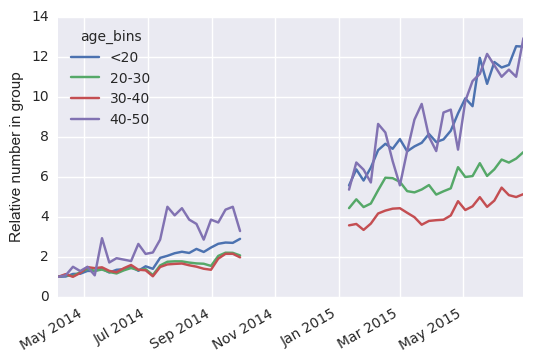

In [73]:
fig, ax = plt.subplots()

ax.set_ylabel('Relative number in group')
ax.set_xlabel('')

df.iloc[:-1].plot(ax=ax)

## Predictions of Future Growth

We use an ARMA (AutoRegressive Moving Average Model) to predict Uber usage by each age demographic per day.
As we can see from this diagram, there is a periocity in the data which we can exploit to predict future values.
We use back testing to evaluate how what we would have predicted 10 days in the past, and then compare this to the actual ground truth.
From visualling inspecting the model, we can see that this model is accurate within a 70% confidence interval.


![](./1.jpg)

![](./2.jpg)

Here we have predictions of future uptake, broken down by demographic age groups

![](./3.jpg)


## Conclusions
Given then above results, we validated our hypthesis: that the the older customer segment is growing most rapidly.
Surpisingly, we also discovered that there was another growth area: under 20's.
Given this, we can say that this is a positive signal for Ube and ride sharing in general.

## Future Challenges
In spite of these positive results, we anticipate many challenges for Uber.
For example, Uber are currently in the midst of a PR nightmare.
Accusations of regular sexual harassment within the company perhaps suggest that uptake will not grow as rapidly as one might expect based on data from 2014 and 2015.
On the other hand, companies like Amazon have experienced similar PR issues, but it seems that they are 'too big to fail': their services are so useful that customers are willing to completely overlook their misgivings about how the company is run.